In [1]:
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

In [2]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [55]:
from pyspark import SparkConf
from pyspark import SparkContext 
from os import listdir
import numpy as np
import os

sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

Reading Data from CSV file

In [3]:
df = pd.read_csv('Region_MIDA.csv', parse_dates=['Local_Time'], index_col = 'Local_Time')
df.head()

,Unnamed: 0,Region,value
Local_Time,,,
2015-07-01 01:00:00,0,MIDA,84024.0
2015-07-01 02:00:00,1,MIDA,79791.0
2015-07-01 03:00:00,2,MIDA,76760.0
2015-07-01 04:00:00,3,MIDA,74931.0
2015-07-01 05:00:00,4,MIDA,74368.0


Plotting hourly raw data

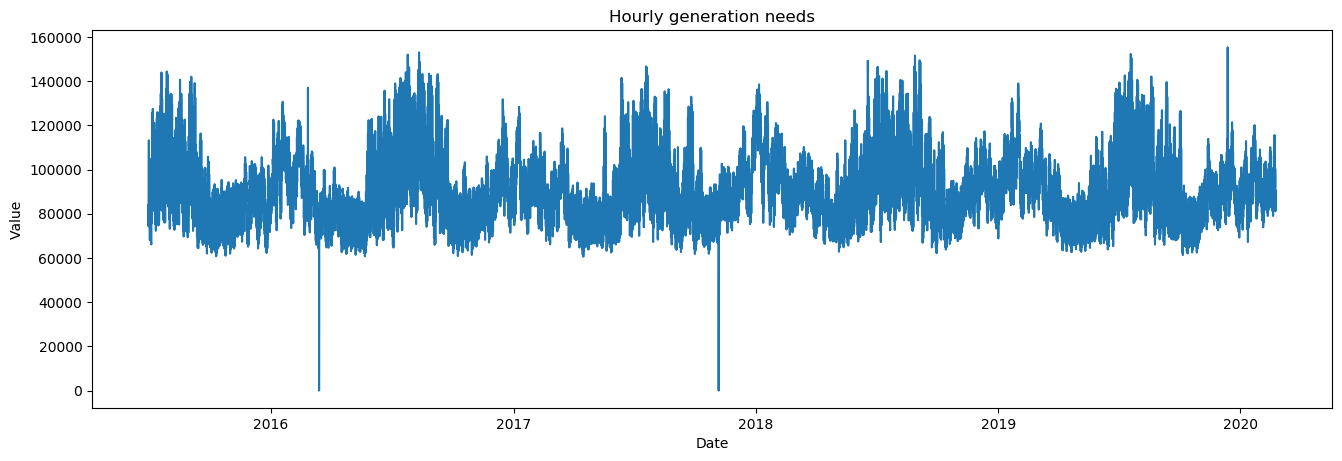

In [4]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df.index, y=df.value, title='Hourly generation needs') 

Adding day, date, hour and year columns for plotting purposes

In [7]:
from datetime import datetime

df.reset_index(inplace = True)
df['dt'] = [datetime.strptime(str(ts),'%Y-%m-%d %H:%M:%S') for ts in df.Local_Time]
day_name= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
df['day'] = [day_name[d.weekday()] for d in df.dt]
df['hour'] = [d.hour for d in df.dt]
df['year'] = [d.year for d in df.dt]
df['date'] = [ts.date() for ts in df.Local_Time]
df.head()


,index,Local_Time,Unnamed: 0,Region,value,dt,day,hour,year,month,date
0,0,2015-07-01 01:00:00,0,MIDA,84024.0,2015-07-01 01:00:00,Wednesday,1,2015,Jul,2015-07-01
1,1,2015-07-01 02:00:00,1,MIDA,79791.0,2015-07-01 02:00:00,Wednesday,2,2015,Jul,2015-07-01
2,2,2015-07-01 03:00:00,2,MIDA,76760.0,2015-07-01 03:00:00,Wednesday,3,2015,Jul,2015-07-01
3,3,2015-07-01 04:00:00,3,MIDA,74931.0,2015-07-01 04:00:00,Wednesday,4,2015,Jul,2015-07-01
4,4,2015-07-01 05:00:00,4,MIDA,74368.0,2015-07-01 05:00:00,Wednesday,5,2015,Jul,2015-07-01


Year-wise and Month-wise boxplot

Yearly average consumption

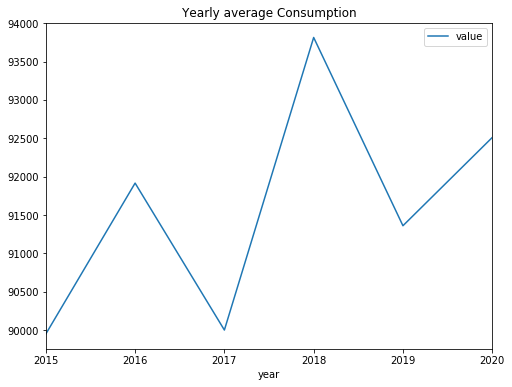

In [37]:
df_year = df.groupby("year")["value"].mean()
df_year.plot(figsize = (8,6))
plt.title("Yearly average Consumption")
plt.legend()
plt.xticks()
plt.show()

From the Yearly average consumption graph, we can observe that the average consumption ranges from 90000 to 94000 per year. 

Monthly Average Consumption

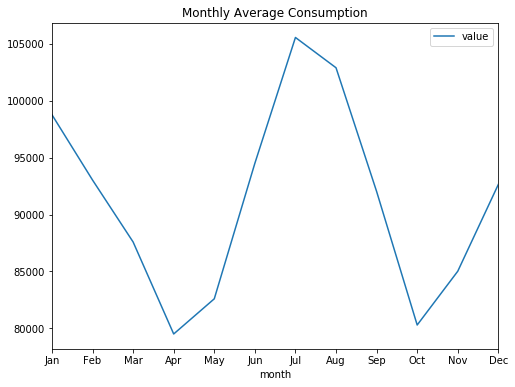

In [34]:
df_month = df.groupby("month")["value"].mean()
order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
df_month = pd.DataFrame(df_month).reset_index()
df_month['month'] = pd.Categorical(df_month['month'], categories= order, ordered=True)
df_month = df_month.sort_values(by = 'month')
df_month = df_month.set_index('month')
df_month.plot(figsize = (8,6), sort_columns = True)
plt.title("Monthly Average Consumption")
plt.xticks(np.arange(len(df_month.index)), df_month.index)
plt.legend()
plt.xticks()
plt.show()

From the monthly average consumption graph we can observe that the consumption is high during peak summer and winter months i.e January and July and low during April and October months.


Yearwise Monthly average consumption

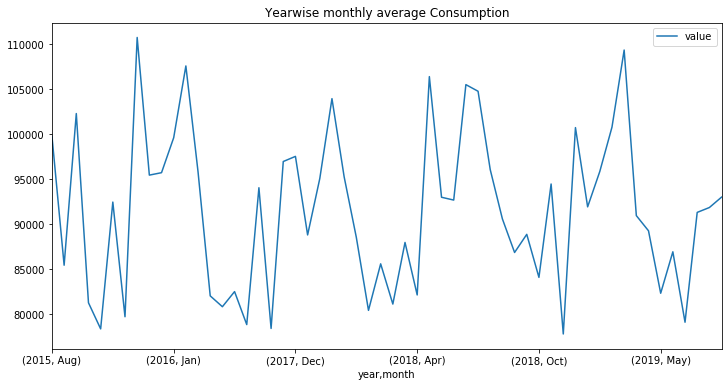

In [39]:
df_monyear = df.groupby(["year","month"])["value"].mean()
df_monyear.plot(figsize = (12,6))
plt.title("Yearwise monthly average Consumption")
plt.legend()
plt.show()

From the yearly average consumption graph, we can observe that peak consumptions are observed during January and June months and low consumptions are observed during April and October months.

Hourly average consumption

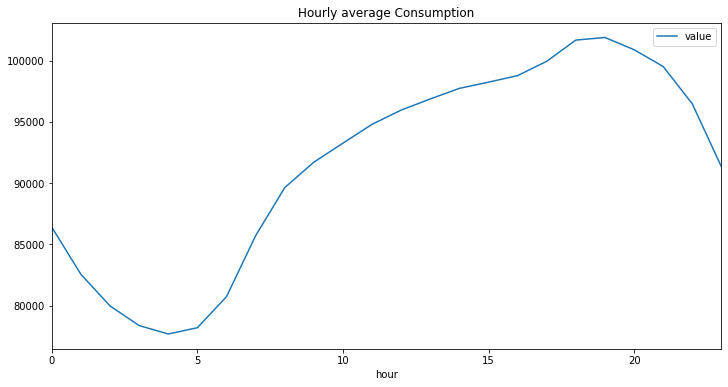

In [40]:
df_hour = df.groupby("hour")["value"].mean()
df_hour.plot(figsize = (12,6))
plt.title("Hourly average Consumption")
plt.legend()
plt.xticks()
plt.show()

From the Hourly average consumption graph, we can observe that the consumption is minimum during early hours of the day and increases from 5 hrs and reaches maximum at 18 hrs and then decreases. 

Day-wise hourly average consumption

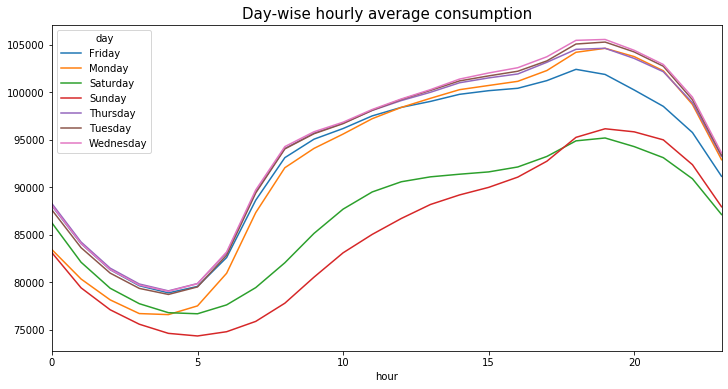

In [41]:
df2 = df.filter(['Local_Time','day','hour','value'], axis = 1)
df_new = df2.pivot_table(values = 'value', index = 'hour', columns = 'day')
df_new.plot(figsize = (12,6))
plt.title("Day-wise hourly average consumption", fontsize = 15)
plt.show()

Day-wise hourly average consumption reveals that the hourly average follows the same pattern every day and consumption is low during weekends - Saturday and Sunday.

ARIMA Model

Data Preprocessing

In [44]:
data = pd.read_csv('spark/Region_MIDA.xlsx')
demand = data['D']
time_column = pd.Series(demand.values, index = pd.date_range('2015-07-01 01:00:00', freq = 'H', periods = len(demand.values))).index
refined_data = pd.DataFrame(columns = ['Time', 'Demand'])
refined_data['Time'] = time_column
refined_data['Demand'] = demand.values
#to convert Time column to DateTime sequence
refined_data['Time'] = pd.to_datetime(refined_data['Time'])
#setting index of the time series to Time column - Date Time Index
refined_data = refined_data.set_index('Time')
#Setting frequency of the time series to Hourly
refined_data = refined_data.resample('H').mean()
#Dropping Null values
refined_data = refined_data.dropna()
refined_data.index

DatetimeIndex(['2015-07-01 01:00:00', '2015-07-01 02:00:00',
               '2015-07-01 03:00:00', '2015-07-01 04:00:00',
               '2015-07-01 05:00:00', '2015-07-01 06:00:00',
               '2015-07-01 07:00:00', '2015-07-01 08:00:00',
               '2015-07-01 09:00:00', '2015-07-01 10:00:00',
               ...
               '2020-02-22 16:00:00', '2020-02-22 17:00:00',
               '2020-02-22 18:00:00', '2020-02-22 19:00:00',
               '2020-02-22 20:00:00', '2020-02-22 21:00:00',
               '2020-02-22 22:00:00', '2020-02-22 23:00:00',
               '2020-02-23 00:00:00', '2020-02-23 01:00:00'],
              dtype='datetime64[ns]', name='Time', length=40753, freq='H')

ADF Test - to test stationarity of data

In [46]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

results = adfuller(refined_data.Demand)
print("Augmented Dickey Fuller Test results:")
print("ADF Test statistic: ",results[0])
print("P-Value: ", results[1])
print("Number of Lags used: ",results[2])
print("Number of Observations used:",results[3])
print("Critical Value 1%: ", results[4]['1%'])
print("Critical Value 5%: ", results[4]['5%'])
print("Critical Value 10%: ", results[4]['10%'])

Augmented Dickey Fuller Test results:
ADF Test statistic:  -11.93919702686752
P-Value:  4.58549888798769e-22
Number of Lags used:  54
Number of Observations used: 40698
Critical Value 1%:  -3.430510688793077
Critical Value 5%:  -2.8616110207887067
Critical Value 10%:  -2.566807802079232


From the results of ADFuller Test, we can observe that p-value is less than significance level(0.05). Hence we reject null hypothesis and confirm that the data is stationary

ACF and PACF plots

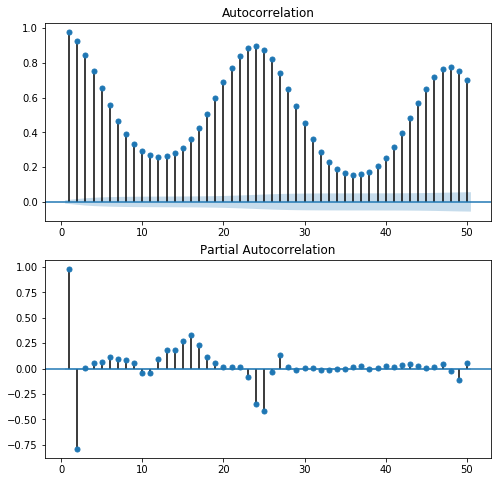

In [47]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(2,1 , figsize = (8,8))

#make ACF plot

plot_acf(refined_data,lags = 50, zero = False, ax = ax1)

#Make PACF PLot
plot_pacf(refined_data, lags = 50, zero = False, ax = ax2)

plt.show()

From the ACF plot, we can observe significant spikes in the data at lags 24 and 48, which implies that the seasonal period of our time series is 24, since we have hourly data. Our series has positive auto correlations for a high number of lags and hence it needs differencing.


First order differencing and ACF and PACF plots for differenced data

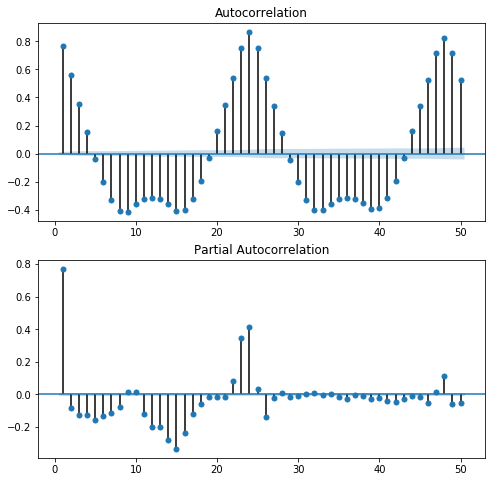

In [48]:
data_diff = refined_data.diff().dropna()

fig, (ax1, ax2) = plt.subplots(2,1 , figsize = (8,8))

#make ACF plot

plot_acf(data_diff,lags = 50, zero = False, ax = ax1)

#Make PACF PLot
plot_pacf(data_diff, lags = 50, zero = False, ax = ax2)

plt.show()

Our series seems slightly under differenced, as we can observe lag1 of ACF is positive and hence we add an AR term to the model. Since our PACF cuts off after lag 1, we can estimate that the order of AR term is 1. Also, ACF cuts off after lag4 and hence order of MA term is 4


Seasonal Differencing

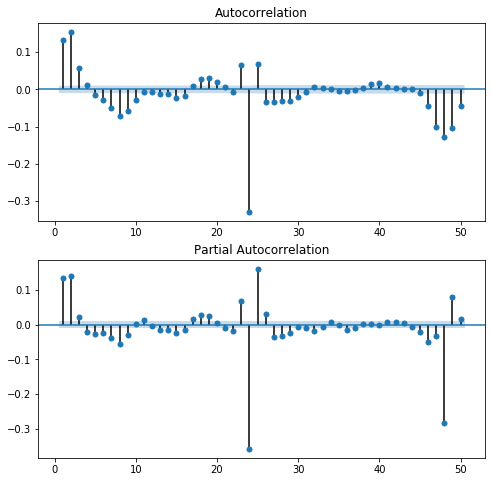

In [49]:
data_sdiff = data_diff.diff(periods = 24).dropna()

fig, (ax1, ax2) = plt.subplots(2,1 , figsize = (8,8))

#make ACF plot

plot_acf(data_sdiff,lags = 50, zero = False, ax = ax1)

#Make PACF PLot
plot_pacf(data_sdiff, lags = 50, zero = False, ax = ax2)

plt.show()

The above ACF and PACF plots are after performing seasonal differencing on the data. Since the orders of P and Q are 3 and 3 respectively, but as per rule 13 defined in https://people.duke.edu/~rnau/arimrule.htm, to avoid over fitting, we should avoid using more than one or two seasonal parameters and hence we tried experimenting with different combinations of seasonal orders such that (SAR+SMA >=2) and (d+D >=2) , adjusting p and q values accordingly and based on AIC and BIC values finalized model with non-seasonal order (1,1,5) and seasonal order (0,0,0,24) as the best model.

Dividing into train and validation sets

In [50]:
train = refined_data[:int(refined_data.size*0.8)]
validation = refined_data[int(refined_data.size*0.8):]

Training the model and forecasting values

In [53]:
#Training the model
model = SARIMAX(train, order=(1, 1, 5), seasonal_order = (0,0,0,24 ), trend = 'c')  
fitted = model.fit(disp=-1)  

# Forecast
fc= fitted.forecast(len(validation), alpha=0.05)  # 95% conf
predicted = fitted.get_forecast(steps = 8157)
#Make as pandas series
fc_series = pd.Series(fc, index=validation.index)

Calculating RMSE and MAPE

In [54]:
mape = np.mean(np.abs(fc-validation['Demand'])/np.abs(validation['Demand']))*100
rmse = np.mean((fc-validation['Demand'])**2)**0.5

print("mape: ",mape)
print("rmse: ", rmse)

mape:  12.985956390414852
rmse:  15449.262823163068


Applying model to all the files in the data set

Function that takes filename as input, performs required preprocessing of data and return test and validation sets

In [56]:
def data_preprocess(filename):
    data = pd.read_csv(filename)
    demand = data['D']
    time_column = pd.Series(demand.values, index = pd.date_range('2015-07-01 01:00:00', freq = 'H', periods = len(demand.values))).index
    refined_data = pd.DataFrame(columns = ['Time', 'Demand'])
    refined_data['Time'] = time_column
    refined_data['Demand'] = demand.values
    
    #to convert Time column to DateTime sequence
    refined_data['Time'] = pd.to_datetime(refined_data['Time'])
    
    #setting index of the time series to Time column - Date Time Index
    refined_data = refined_data.set_index('Time')
    
    #Setting frequency of the time series to Hourly
    refined_data = refined_data.resample('H').mean()
    
    #Dropping NaN
    refined_data = refined_data.dropna()
    
    #Splitting data into Train and validation sets - 80% Train and 20% Validation
    train = refined_data[:int(refined_data.size*0.8)]
    validation = refined_data[int(refined_data.size*0.8):] 
    
    return train, validation

Function that takes train and validation sets as input, applies SARIMA model on training set, forecasts the values,
computes RMSE and MAPE using validation data and returns RMSE and MAPE values

In [57]:
def arimaModel(df_train, df_validation):
    #Applying SARIMAX model on training set
    model = SARIMAX(df_train, order=(1, 1, 5), seasonal_order = (0,0,0,24 ), trend = 'c')  
    
    #Fitting the model
    fitted = model.fit(disp=-1)  
    
    #Forecasting the values with steps equal to length of validation set with 95% COnfidence Interval
    fc= fitted.forecast(len(df_validation), alpha=0.05)  # 95% conf
    
    #Getting forecasted values
    predicted = fitted.get_forecast(steps = len(df_validation))
    fc_series = pd.Series(fc, index=df_validation.index)
    
    #Calculating rmse and mape
    mape = np.mean(np.abs(fc- df_validation['Demand'])/np.abs(df_validation['Demand']))*100
    rmse = np.mean((fc- df_validation['Demand'])**2)**0.5
    return rmse, mape

Applying ARIMA model to all the files in the dataset

In [58]:
path = 'C:/Users/ViJaY/Desktop/ADS/Spring 2020/Cloud Computing/Project/spark'
rdd = sc.wholeTextFiles('C:/Users/ViJaY/Desktop/ADS/Spring 2020/Cloud Computing/Project/spark/*')
rdd_1 = rdd.map(lambda x: (x[0].split("/")[-1], x[1]))
rdd_2 = rdd_1.map(lambda x: (x[0], data_preprocess(os.path.join(path, x[0]))))
rdd_3 = rdd_2.map(lambda x: (x[0], arimaModel(x[1][0], x[1][1])))
results = rdd_3.collect()
results = [[x[0], round(x[1][0],2), round(x[1][1],2)] for x in results]
res = pd.DataFrame(results)
res.columns = ['FileName','RMSE','MAPE']
res

,FileName,RMSE,MAPE
0,Region_CAL.xlsx,10210.58,26.42
1,Region_CAR.xlsx,6054.14,15.96
2,Region_CENT.xlsx,6089.76,106.17
3,Region_FLA.xlsx,10491.16,26.50
4,Region_MIDA.xlsx,15449.26,12.99
5,Region_MIDW.xlsx,13068.11,11.60
6,Region_NE.xlsx,2479.66,13.90
7,Region_NW.xlsx,5533.36,10.88
8,Region_NY.xlsx,3313.90,inf
9,Region_SE.xlsx,9153.47,23.36



From the above results we can observe that the ARIMA model didn’t converge for the files Region_TEN and Region_TEX and hence the Null values in the results.
